In [4]:
import rasterio
import math
import numpy as np
import matplotlib.pyplot as plt
import os
from rasterio.windows import Window
import random
from rasterio.plot import reshape_as_raster, reshape_as_image
from glob import glob
import rnn_pixels

In [5]:
def normalize_rgb(tile):
    tile = tile[[2, 1, 0],:,:].astype(np.float64)
    print(tile.shape)
    max_val = 4000
    min_val = 0
    # Enforce maximum and minimum values
    tile[tile[:, :, :] > max_val] = max_val
    tile[tile[:, :, :] < min_val] = min_val
    for b in range(tile.shape[0]):
        tile[b, :, :] = tile[b, :, :] * 1 / (max_val - min_val)
    tile_reshaped = reshape_as_image(tile)
    return tile_reshaped

In [13]:
def view_landsat(landsat):
    #image_dataset = landsat
    full_img = landsat.read()
    colors_reshaped = normalize_rgb(full_img)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(colors_reshaped)
    ax.set_title("RGB in matplotlib imshow")

In [14]:
def make_combined(tile_number, ls8_filepaths, dates):
    j = 0
    for ls8_fp in ls8_filepaths:
        ls8_band_paths = glob(ls8_fp + '*SRB*')
        ls8_band_paths.sort()
        ls8_band_paths += glob(ls8_fp + '*PIXELQA*')
        img_fp = '/deep_data/recurrent_data/' + 'tile' + tile_number + '/' + 'combined/' + 'combined' +dates[j]+'.tif'
        j+=1
        # Read metadata of first file and assume all other bands are the same
        with rasterio.open(ls8_band_paths[0]) as src0:
            meta = src0.meta
        # Update metadata to reflect the number of layers
        meta.update(count = len(ls8_band_paths)+1) #add 1 because ndvi
        # Read each layer and write it to stack
        with rasterio.open(img_fp, 'w', **meta) as dst:
            for id, layer in enumerate(ls8_band_paths, start=1):
                print(layer)
                if id < 7:
                    with rasterio.open(layer) as src1:
                        dst.write_band(id, src1.read(1))
                        if id == 5:
                            red = src1.read(1)
                        elif id == 6:
                            nir = src1.read(1)
                else:
                    ndvi = (nir.astype(float) - red.astype(float)) / (nir.astype(float) + red.astype(float) + 0.0000001)
                    ndvi *= 10000
                    dst.write_band(id, ndvi.astype(np.int16))
                    with rasterio.open(layer) as src1:
                        dst.write_band(id+1, src1.read(1).astype(np.int16)) # this one otherwise is uint16 for some reason    

In [15]:
tiles = {}
tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']

In [9]:
for tile_number, dates in tiles.items():
    ls8_filepaths = []
    for date in dates:
        ls8_filepaths.append('/deep_data/recurrent_data/tile'+tile_number+'/date'+date+'/')
    make_combined(tile_number, ls8_filepaths, dates)

/deep_data/recurrent_data/tile028012/date20110324/LT05_CU_028012_20110324_20181214_C01_V01_SRB1.tif
/deep_data/recurrent_data/tile028012/date20110324/LT05_CU_028012_20110324_20181214_C01_V01_SRB2.tif
/deep_data/recurrent_data/tile028012/date20110324/LT05_CU_028012_20110324_20181214_C01_V01_SRB3.tif
/deep_data/recurrent_data/tile028012/date20110324/LT05_CU_028012_20110324_20181214_C01_V01_SRB4.tif
/deep_data/recurrent_data/tile028012/date20110324/LT05_CU_028012_20110324_20181214_C01_V01_SRB5.tif
/deep_data/recurrent_data/tile028012/date20110324/LT05_CU_028012_20110324_20181214_C01_V01_SRB7.tif
/deep_data/recurrent_data/tile028012/date20110324/LT05_CU_028012_20110324_20181214_C01_V01_PIXELQA.tif
/deep_data/recurrent_data/tile028012/date20110612/LT05_CU_028012_20110612_20181213_C01_V01_SRB1.tif
/deep_data/recurrent_data/tile028012/date20110612/LT05_CU_028012_20110612_20181213_C01_V01_SRB2.tif
/deep_data/recurrent_data/tile028012/date20110612/LT05_CU_028012_20110612_20181213_C01_V01_SRB3.t

/deep_data/recurrent_data/tile028011/date20111103/LT05_CU_028011_20111103_20190508_C01_V01_SRB7.tif
/deep_data/recurrent_data/tile028011/date20111103/LT05_CU_028011_20111103_20190508_C01_V01_PIXELQA.tif


In [10]:
landsat_datasets = {}
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

(3, 5000, 5000)


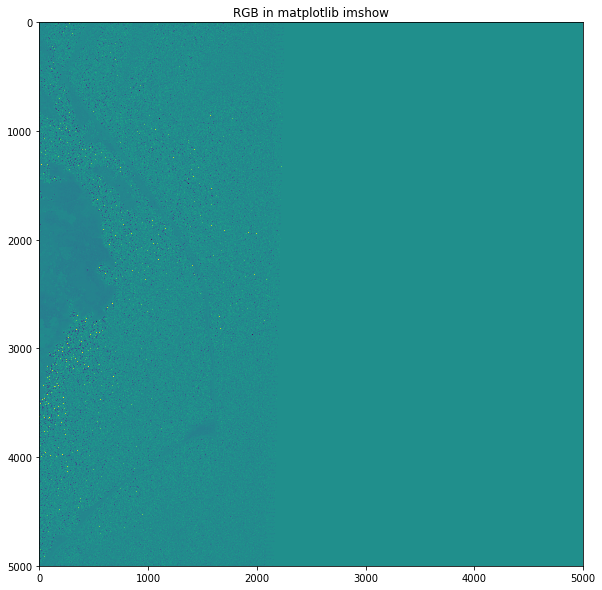

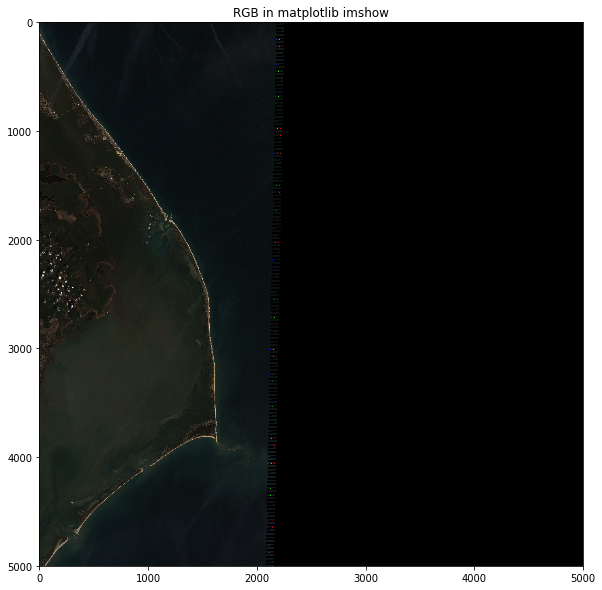

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(landsat_datasets['029011'][0].read()[6])
ax.set_title("RGB in matplotlib imshow")
view_landsat(landsat_datasets['029011'][0])


(3, 5000, 5000)
(3, 5000, 5000)
(3, 5000, 5000)
(3, 5000, 5000)


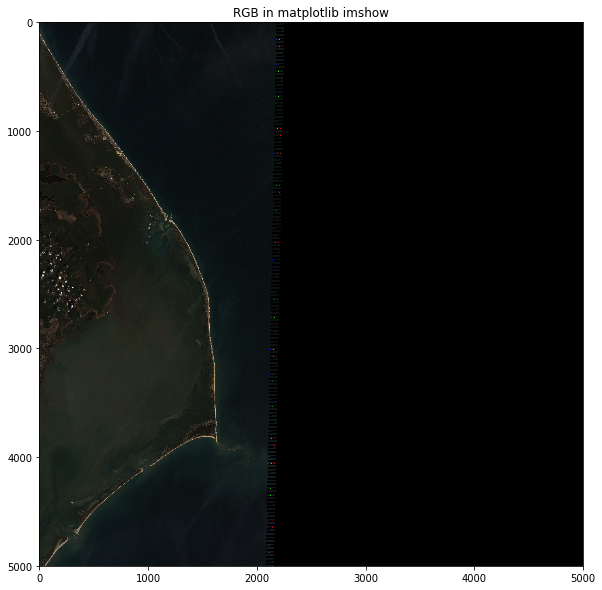

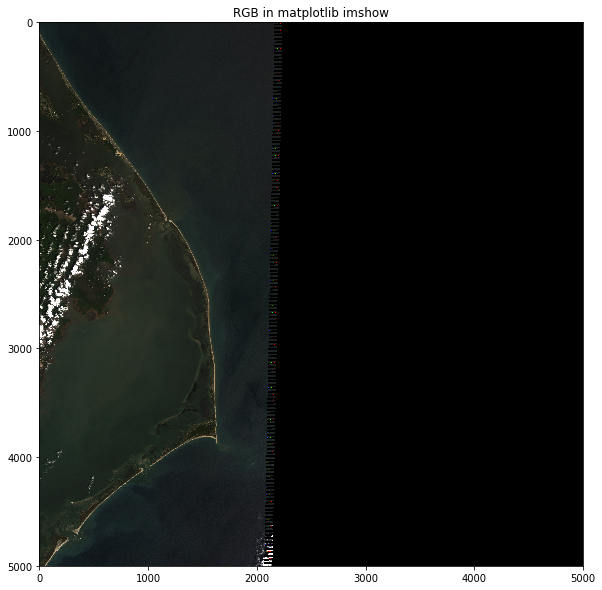

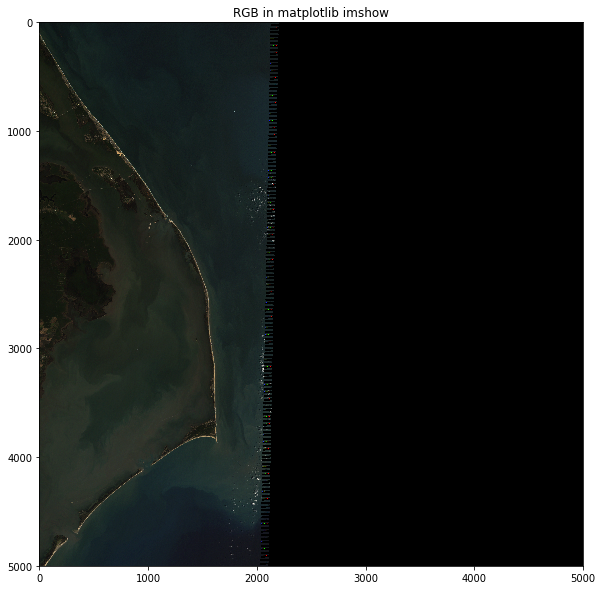

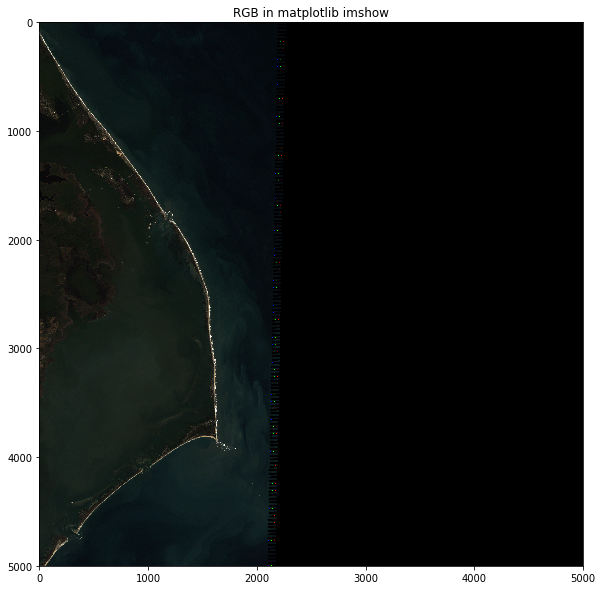

In [18]:
view_landsat(landsat_datasets['029011'][0])
view_landsat(landsat_datasets['029011'][1])
view_landsat(landsat_datasets['029011'][2])
view_landsat(landsat_datasets['029011'][3])

In [8]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

In [9]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')
#terio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSAnalytical_2_8_16/Analytical/nlcd2011_usfs_conus_canopy_analytical.img')


In [12]:
tile_size = 64
tile_list = ['028012', '029011', '028011']

In [25]:
import rnn_tiles
import importlib
importlib.reload(rnn_tiles)
importlib.reload(rnn_pixels)

<module 'rnn_pixels' from '/host/Desktop/cnn_dev/florence_mapping/rcnn/rnn_pixels.py'>

In [26]:
pixels = rnn_pixels.make_pixels(tile_size, tile_list)
new_px = rnn_pixels.delete_bad_tiles(landsat_datasets, lc_labels, canopy_labels, pixels, 64)

In [28]:
print(len(new_px))

3576


In [17]:
print(len(new_px))

3873


In [68]:
plt.close('all')

In [10]:
gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, 64, 6)

In [11]:
generator = gen.tile_generator(new_px, 1)

NameError: name 'new_px' is not defined

In [124]:
l8_data, labels = next(generator)

In [125]:
l8_data = l8_data.reshape((4, 64, 64, 7))

(3, 64, 64)


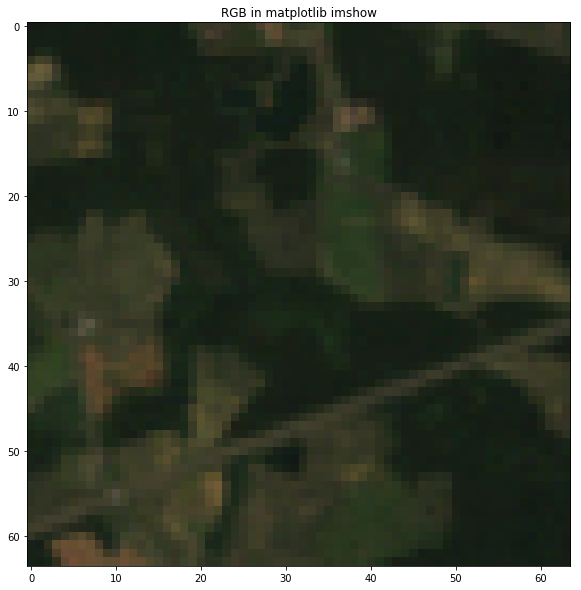

In [126]:
view_landsat(reshape_as_raster(l8_data[1]))


In [131]:
def show_labels(label):
    label = np.argmax(labels, axis=-1)
    label = label.reshape(64, 64)
    color_label = np.zeros((64, 64, 3))
    colors = {0:(0,0,255), 1:(255, 0, 0), 2:(0, 255, 0), 3:(153, 153,0), 4:(255,255, 255), 5:(0, 153, 153)}
    for i in range(64):
        for j in range(64):
            color_label[i][j] = colors[label[i][j]]
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(color_label)
    ax.set_title("RGB in matplotlib imshow")

In [188]:
label.shape

(64, 64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'RGB in matplotlib imshow')

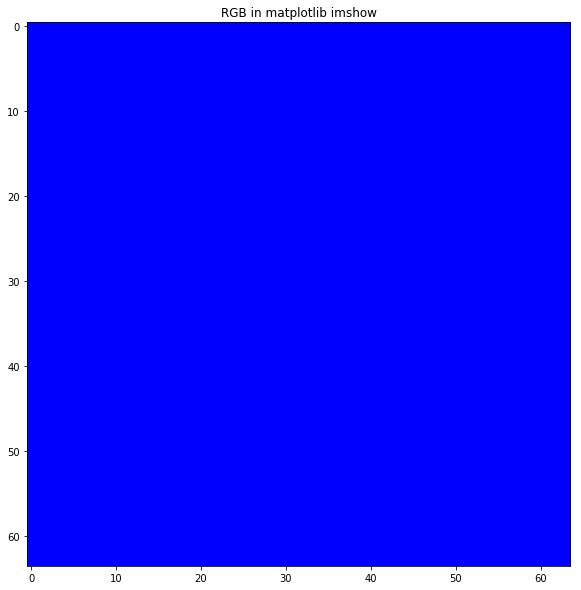

In [92]:
print("{}".format(lc_labels.height))
print("{}".format(lc_labels.width))

104424
161190


In [76]:
print(r)

(4960, 4960)


In [93]:
l8, labels = next(generator)

[[0.97 0.98 0.97 ... 0.   0.   0.  ]
 [0.95 0.94 0.98 ... 0.   0.   0.  ]
 [0.89 0.98 0.98 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.24]
 [0.   0.   0.   ... 0.   0.   0.52]]
1
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
2
[[0.94 0.91 0.95 ... 0.98 0.98 0.96]
 [0.96 0.9  0.99 ... 0.95 0.95 0.96]
 [0.96 0.99 0.92 ... 0.95 0.92 0.95]
 ...
 [0.84 0.89 0.95 ... 0.92 0.93 0.91]
 [0.85 0.71 0.92 ... 0.93 0.93 0.94]
 [0.45 0.65 0.74 ... 0.93 0.93 0.86]]
3
[[0.86 0.91 0.9  ... 0.98 0.98 0.99]
 [0.86 0.94 0.9  ... 0.99 1.   1.  ]
 [0.86 0.94 0.9  ... 1.   0.99 1.  ]
 ...
 [0.96 0.96 0.96 ... 0.95 0.97 0.92]
 [0.99 0.98 0.96 ... 0.93 0.92 0.95]
 [0.98 0.98 0.96 ... 0.96 0.95 0.93]]
4
[[0.35 0.75 0.86 ... 0.9  0.91 0.9 ]
 [0.32 0.37 0.82 ... 0.92 0.9  0.91]
 [0.26 0.22 0.74 ... 0.91 0.91 0.88]
 ...
 [0.97 0.94 0.98 ... 0.32 0.29 0.76]

In [28]:
points = make_pixels(64)

In [38]:
new_px = rnn_pixels.delete_bad_tiles(landsat_datasets, points, 64)

In [39]:
len(new_px)

6143

In [11]:
list_of_data = []
for key, item in landsat_datasets.items():
    list_of_data.append(item)

In [13]:
all_l8 = []
for lists in list_of_data:
    for item in lists:
        all_l8.append(item)
    

In [28]:
band_totals = np.zeros(7)
std_totals = np.zeros(7)
for l8 in all_l8:
    img = l8.read()
    img[img == -9999] = 0
    for i in range(7):
        band_totals[i] += np.mean(img[i])
        std_totals[i] += np.std(img[i])

In [29]:
band_totals / 12

array([  345.72448081,   352.93755735,   319.34257128,   899.39728239,
         649.46125258,   370.53562465, -1084.8218946 ])

In [32]:
std_totals / 12

array([ 661.75737932,  363.32761072,  425.28671553,  959.63442896,
        838.86193201,  501.96992987, 3562.42995552])